<a href="https://colab.research.google.com/github/Aditi1203/CMPE-295/blob/master/Final_MIT_Loss_Early_Stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Aditi1203/CMPE-295.git

Cloning into 'CMPE-295'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1152138 (delta 2), reused 0 (delta 0), pack-reused 1152132
Receiving objects: 100% (1152138/1152138), 3.34 GiB | 14.95 MiB/s, done.
Resolving deltas: 100% (220402/220402), done.
Checking out files: 100% (738053/738053), done.


In [2]:
cd CMPE-295/anand_sandbox/

/content/CMPE-295/anand_sandbox


In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import imutils
import random
# from keras.applications import VGG19, VGG16
# from keras.applications.vgg19 import preprocess_input
# from keras.applications.vgg16 import preprocess_input
from itertools import permutations
from keras.optimizers import SGD,Adam
from PIL import Image
import keras
from keras import backend as K
from keras import Sequential, losses, optimizers, Input, optimizers
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.layers import Flatten, Lambda, Dense, Conv2D, MaxPool2D, Average, Dropout, Activation
from keras.utils import to_categorical, plot_model,vis_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard, EarlyStopping
from keras.preprocessing.image import img_to_array
from itertools import chain 
from skimage import io
import imutils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pywt
from scipy import signal
from scipy.spatial import distance

Using TensorFlow backend.


In [0]:
def load_data(number_of_items=3):
    """
        number_of_items -> Number of items to return
        returns the data in a dictionary of images and labels.
    """
    path = "scalogram_module/Scalogram"
    path1= "scalogram_module/Scalogram/Cropped"
    data = [] 
    curated_data = {"label":[], "scalogram":[]}
    for subject_name in os.listdir(path)[:number_of_items]:
        if subject_name == ".DS_Store":
            number_of_items=number_of_items+1
            continue
        if subject_name  ==".ipynb_checkpoints":
            number_of_items=number_of_items+1
            continue
        print ("Going through subject:" + subject_name)
        base=os.path.basename(path+"/"+subject_name)
        labelData=os.path.splitext(base)[0]
        print(labelData)
        i=0
        for items in os.listdir(path+"/"+subject_name):
            if items == ".DS_Store":
                continue
            if items.endswith(".png"):
                try:
                    im2 = cv2.imread(path+"/"+subject_name+"/"+items)
                    crop_img = im2[30:20+235, 50:50+342]
                    im = cv2.resize(crop_img, (224,224)) # Changing into 80x80X3
                    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                    curated_data['scalogram'].append(im)
                    curated_data['label'].append(labelData)
                except:
                      df = None  

    return curated_data

## **Data Loading & Pre-processing**

In [5]:
data = load_data(number_of_items=50)

Going through subject:person_207
person_207
Going through subject:person_111
person_111
Going through subject:person_228
person_228
Going through subject:person_223
person_223
Going through subject:person_213
person_213
Going through subject:person_214
person_214
Going through subject:person_109
person_109
Going through subject:person_212
person_212
Going through subject:person_208
person_208
Going through subject:person_202
person_202
Going through subject:person_219
person_219
Going through subject:person_230
person_230
Going through subject:person_100
person_100
Going through subject:person_106
person_106
Going through subject:person_102
person_102
Going through subject:person_123
person_123
Going through subject:person_118
person_118
Going through subject:person_103
person_103
Going through subject:person_222
person_222
Going through subject:person_232
person_232
Going through subject:person_221
person_221
Going through subject:person_209
person_209
Going through subject:person_201

In [6]:
print(data['scalogram'][0].shape)
print(len(data['scalogram']))

(224, 224)
50605


In [7]:
len(data['label'])

50605

In [7]:
data_array=np.array(data['scalogram'])
labels=np.array(data['label'])
print("Data shape:{}".format(data_array.shape))
print("Labels shape:{}".format(labels.shape))

Data shape:(50605, 224, 224)
Labels shape:(50605,)


In [0]:
# data_array = data_array / 255.0

In [8]:
encoder = LabelEncoder()
encoder.fit(labels)
labels = encoder.transform(labels)
print("Encoded Labels shape:{} value:{}".format(labels.shape,labels))

Encoded Labels shape:(50605,) value:[28 28 28 ...  8  8  8]


In [9]:
unique_labels=set(labels)
print(unique_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}


In [0]:
x_train, x_test, y_train,  y_test=train_test_split(data_array, labels, test_size=0.2, random_state=2)


In [11]:
print("Shapes:")
print("Train Data:{}".format(x_train.shape))
print("Train Label:{}".format(y_train.shape))
print("Test Data:{}".format(x_test.shape))
print("Test Label:{}".format(y_test.shape))

Shapes:
Train Data:(40484, 224, 224)
Train Label:(40484,)
Test Data:(10121, 224, 224)
Test Label:(10121,)


In [12]:
x_train_master = np.expand_dims(x_train, 3)
x_test_master = np.expand_dims(x_test, 3)
print(x_train.shape, x_test.shape)

(40484, 224, 224) (10121, 224, 224)


In [13]:
y_train_master = y_train.flatten()
y_test_master = y_test.flatten()
print(y_train_master.shape,y_test_master.shape)

(40484,) (10121,)


In [14]:
shape=x_train.shape
dim_x = shape[1]
dim_y = shape[2]
print("Dimension of Scalogram Image: {}*{}".format(dim_x,dim_y ))

Dimension of Scalogram Image: 224*224


## **Triplets Generation & Visualization**

In [0]:
def generate_triplets(dataset, label, sample_per_class=20):
    x, y = None, None
    for i in set(label):
        pos_indices = np.argwhere(label == i)[:,0]
        neg_indices = np.argwhere(label != i)[:,0]

        # print("pos indices: {}, neg_indices: {}".format(pos_indices.shape, neg_indices.shape))
        choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=True)
        choice_anchor = pos_indices[choice_anchor]

        choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=True)
        choice_pos = pos_indices[choice_pos]

        choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=True)
        choice_neg = neg_indices[choice_neg]

        sub_x_anc = dataset[choice_anchor]

        sub_x_pos = dataset[choice_pos]

        sub_x_neg = dataset[choice_neg]


        if(x is None):
            x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
            y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
        else:
            x[0] = np.vstack((x[0], (sub_x_anc)))
            x[1] = np.vstack((x[1], (sub_x_pos)))
            x[2] = np.vstack((x[2], (sub_x_neg)))

            y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
            y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
            y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))

    return x, y

In [0]:
num=500
num_train_per_class=int(num*.80)
num_test_per_class=int(num*.20)

In [0]:
train_x, train_y = generate_triplets(x_train_master, y_train_master, num_train_per_class)

In [0]:
test_x, test_y = generate_triplets(x_test_master, y_test_master,num_test_per_class)

In [283]:
print("Length of generated triplet for Train Data:{},{}".format(len(train_x),train_x[0].shape))
print("Length of generated triplet for Test Data:", len(test_x),test_x[0].shape)
print("Length of generated triplet for Train Label:{},{}".format(len(train_y),train_y[0].shape))
print("Length of generated triplet for Test Label:", len(test_y),test_y[0].shape)

Length of generated triplet for Train Data:3,(19200, 224, 224, 1)
Length of generated triplet for Test Data: 3 (4800, 224, 224, 1)
Length of generated triplet for Train Label:3,(19200,)
Length of generated triplet for Test Label: 3 (4800,)


In [0]:
def visualize_data(data, n):
    n = min(len(data[0]), n)
    random_choices = np.random.choice(len(data[0]),n, replace=False)
    fig, ax = plt.subplots(n, 3,figsize=(10,40))
    anc, pos, neg = data
    for i,ch in enumerate(random_choices):
        ax[i, 0].imshow(np.squeeze(anc[ch] ))
        ax[i, 1].imshow(np.squeeze(pos[ch] ))
        ax[i, 2].imshow(np.squeeze(neg[ch] ))


        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()

In [0]:
visualize_data(train_x, 10)

## **Cost Function: Triplet-Loss**

In [0]:
def triplet_loss(inputs, dist='euclidean', margin='maxplus'):
    print("loss calculation")
    alpha=0.70
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, alpha + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)

## **Models for authentication**

In [0]:
def our_model(in_dims):
   model = Sequential()
   model.add(Conv2D(64, kernel_size=5, input_shape=(in_dims[0],in_dims[1],in_dims[2],), activation="relu"))
   model.add(MaxPool2D(pool_size=(2, 2)))
  #  model.add(Dropout(0.25))
   model.add(Conv2D(64, kernel_size=5, activation="relu"))
   model.add(MaxPool2D(pool_size=(2, 2)))
   model.add(Conv2D(128, kernel_size=5, activation="relu"))
   model.add(MaxPool2D(pool_size=(2, 2)))
   model.add(Conv2D(128, kernel_size=5, activation="relu"))
   model.add(MaxPool2D(pool_size=(2, 2)))
   model.add(Dropout(0.30)) 
   return model

In [0]:
from keras.models import load_model

def create_base_network(in_dims, embedding_dim):

    _input = Input(shape=in_dims)
    our_model_object=our_model(in_dims)
    output_ourModel = our_model_object(_input)

    x = Flatten()(output_ourModel)
    x = Dense(embedding_dim * 4,activation="relu")(x)
    x = Dense(embedding_dim * 2, activation='relu')(x)
    x = Dense(embedding_dim)(x)
    
    return Model(_input, x)

In [0]:
def network_model(input_shape, triplet_margin=.3, embedding_dim=50):

  anchor_input = Input((dim_x,dim_y,1, ), name='anchor_input')
  positive_input = Input((dim_x,dim_y,1, ), name='positive_input')
  negative_input = Input((dim_x,dim_y,1, ), name='negative_input')

  Shared_DNN=create_base_network(input_shape, embedding_dim)
  
  encoded_anchor = Shared_DNN(anchor_input)
  encoded_positive = Shared_DNN(positive_input)
  encoded_negative = Shared_DNN(negative_input)

  inputs=[anchor_input, positive_input, negative_input]
  outputs=[encoded_anchor, encoded_positive, encoded_negative]

  triplet=Model(inputs=inputs, outputs=outputs)
  triplet.add_loss((triplet_loss(outputs, dist='euclidean', margin='maxplus'))) 

  return Shared_DNN, triplet



In [477]:
#print(dim_x)
Shared_DNN, triplet= network_model((dim_x,dim_y,1), triplet_margin=.3, embedding_dim=150)

loss calculation


In [478]:
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizers.RMSprop(),metrics=['accuracy'])
triplet.compile(loss=None, optimizer=optimizers.RMSprop(lr=0.0001))
triplet.summary()
# Adam(0.0001)

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
model_19 (Model)                (None, 150)          8624834     anchor_input[0][0]               
                                                                 positive_input[0][0]      

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output model_19 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_19.
  'be expecting any data to be passed to {0}.'.format(name))


In [0]:
tensorboard = TensorBoard()
earlystopping = EarlyStopping(patience=3)

In [480]:
## Training
n_epochs=50
#my_model.fit(features_train, labels_train, epochs=100, batch_size=16, callbacks=[tensorboard,earlystopping], validation_data=(features_test, labels_test))
history = triplet.fit(train_x, shuffle=True, batch_size=64, validation_split=.2, callbacks=[tensorboard,earlystopping], epochs=n_epochs)

Train on 15360 samples, validate on 3840 samples
Epoch 1/50
15360/15360 [==============================] - 61s 4ms/step - loss: 0.3388 - val_loss: 0.2002
Epoch 2/50
15360/15360 [==============================] - 61s 4ms/step - loss: 0.1551 - val_loss: 0.2061
Epoch 3/50
15360/15360 [==============================] - 61s 4ms/step - loss: 0.1279 - val_loss: 0.1739
Epoch 4/50
15360/15360 [==============================] - 61s 4ms/step - loss: 0.1100 - val_loss: 0.1858
Epoch 5/50
15360/15360 [==============================] - 61s 4ms/step - loss: 0.0947 - val_loss: 0.1601
Epoch 6/50
15360/15360 [==============================] - 61s 4ms/step - loss: 0.0873 - val_loss: 0.1617
Epoch 7/50
15360/15360 [==============================] - 61s 4ms/step - loss: 0.0809 - val_loss: 0.1754
Epoch 8/50
15360/15360 [==============================] - 61s 4ms/step - loss: 0.0729 - val_loss: 0.1694


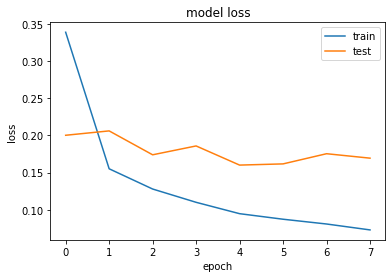

In [481]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
triplet.save("MITTripletLossAditiWithEarlyStop.h5") #

## **Get the Encoding/Embedding Value for Train data(Anchor, Positive, Negative)**

In [0]:
train_anchor_embeds=Shared_DNN.predict(train_x[0])

In [0]:
train_positive_embeds=Shared_DNN.predict(train_x[1])

In [0]:
train_negative_embeds=Shared_DNN.predict(train_x[2])

In [484]:
print("Shape of Embeddings for Train(Anchor) data:{}".format(train_anchor_embeds.shape))
print("Shape of Embeddings for Train(positive) data:{}".format(train_positive_embeds.shape))
print("Shape of Embeddings for Train(negative) data:{}".format(train_negative_embeds.shape))

Shape of Embeddings for Train(Anchor) data:(19200, 150)
Shape of Embeddings for Train(positive) data:(19200, 150)
Shape of Embeddings for Train(negative) data:(19200, 150)


### **Get value of k templates for each label using trained data**

In [0]:
# Get the embeddings of the images
def get_image_embedding(test_model, input): 
  train_embeds = test_model.predict(input)
  return train_embeds

In [486]:
train_embeds=get_image_embedding(Shared_DNN, train_x[0])
print("Train Embeddings shape:{}".format(train_embeds.shape))
#print(train_embeds[0], train_embeds[1])

Train Embeddings shape:(19200, 150)


In [0]:
train_data_v_stack = np.vstack((train_x[0], train_x[1], train_x[2]))

In [0]:
train_label_v_stack = np.vstack((train_y[0], train_y[1], train_y[2]))

In [489]:
print("Shape of vertical_stacked train data: {}".format(train_data_v_stack.shape))
print("Shape of vertical_stacked train label in form of [[],[],[]]: {}".format(train_label_v_stack.shape))
print("Labels of Anchor Image:{}".format(train_label_v_stack[0]))

Shape of vertical_stacked train data: (57600, 224, 224, 1)
Shape of vertical_stacked train label in form of [[],[],[]]: (3, 19200)
Labels of Anchor Image:[ 0  0  0 ... 47 47 47]


In [490]:
print(train_y[1].shape)

(19200,)


### **Calculating Threshold using Trained Data**

In [491]:
map_threshold_calc={}
for unique_label in unique_labels:
  print(unique_label)
  target_label=np.argwhere(train_label_v_stack[1]==unique_label)
  # List of list format,So need to change into single list using chain
  target_label = list(chain.from_iterable(target_label)) 
  start_index=target_label[0]
  end_index=target_label[-1]
  # Data stored of Positive Image value for threshold calculation
  data_per_label_threshold=train_positive_embeds[start_index:end_index+1]
  map_threshold_calc[unique_label]=data_per_label_threshold
  # print(map_threshold_calc[unique_label].shape)

0
(400, 150)
1
(400, 150)
2
(400, 150)
3
(400, 150)
4
(400, 150)
5
(400, 150)
6
(400, 150)
7
(400, 150)
8
(400, 150)
9
(400, 150)
10
(400, 150)
11
(400, 150)
12
(400, 150)
13
(400, 150)
14
(400, 150)
15
(400, 150)
16
(400, 150)
17
(400, 150)
18
(400, 150)
19
(400, 150)
20
(400, 150)
21
(400, 150)
22
(400, 150)
23
(400, 150)
24
(400, 150)
25
(400, 150)
26
(400, 150)
27
(400, 150)
28
(400, 150)
29
(400, 150)
30
(400, 150)
31
(400, 150)
32
(400, 150)
33
(400, 150)
34
(400, 150)
35
(400, 150)
36
(400, 150)
37
(400, 150)
38
(400, 150)
39
(400, 150)
40
(400, 150)
41
(400, 150)
42
(400, 150)
43
(400, 150)
44
(400, 150)
45
(400, 150)
46
(400, 150)
47
(400, 150)


In [0]:
from scipy.spatial import distance

In [605]:
map_threshold_value={}
for key in map_threshold_calc.keys():
  data=map_threshold_calc[key]
  # print(data)
  dists = distance.cdist(data, data, 'euclidean')
  print(dists.shape)
  average_calc=[]
  for dist in dists:
    mean=np.mean(dist)
    standard_deviation=np.std(dist)
    dist_mean=abs(dist-mean)
    soln_array=dist_mean<standard_deviation*0.55
    soln_array1=dist[soln_array]
    maximum=max(soln_array1)
    average_calc.append(maximum)
  threshold_for_label = sum(average_calc)/len(average_calc)
  print("Threshold for Label {}:{}".format(key, threshold_for_label))
  map_threshold_value[key]=threshold_for_label

(400, 400)
Threshold for Label 0:0.7991815570442253
(400, 400)
Threshold for Label 1:0.785807499030897
(400, 400)
Threshold for Label 2:1.1474813046316055
(400, 400)
Threshold for Label 3:0.9736081490192006
(400, 400)
Threshold for Label 4:1.408532676579263
(400, 400)
Threshold for Label 5:0.4989526214561703
(400, 400)
Threshold for Label 6:1.2350701090883245
(400, 400)
Threshold for Label 7:0.7577568521793988
(400, 400)
Threshold for Label 8:1.1935530918474082
(400, 400)
Threshold for Label 9:0.5696509366305607
(400, 400)
Threshold for Label 10:1.27563854343277
(400, 400)
Threshold for Label 11:0.8653758654316601
(400, 400)
Threshold for Label 12:1.0755024583017183
(400, 400)
Threshold for Label 13:1.432493560659668
(400, 400)
Threshold for Label 14:0.7945451183585465
(400, 400)
Threshold for Label 15:0.8068630005676763
(400, 400)
Threshold for Label 16:1.6414761972276763
(400, 400)
Threshold for Label 17:0.8226252588666533
(400, 400)
Threshold for Label 18:0.8227078249030655
(400, 40

## **Brute-Force Testing**

In [606]:
print("What is your claimed identity?")
claimed_label=input()
print(claimed_label)

What is your claimed identity?
0
0


In [0]:
def get_k_template_values(label):
  label=int(label)
  target_label=np.argwhere(train_label_v_stack[0]==label)
  # List of list format.So need to change into single list using chain
  target_label = list(chain.from_iterable(target_label)) 
  #print(target_label)

  k_template_value=[]
  for value in target_label:
    k_template_value.append(train_embeds[value])
  #print("K templates, Value of k:{}, template shape:{}".format(len(k_template_value), len(k_template_value[0])))
  return k_template_value

In [0]:
k_template_value=get_k_template_values(claimed_label)

In [609]:
test_data_v_stack=np.vstack((test_x[0], test_x[1], test_x[2]))
test_label_v_stack=np.vstack((test_y[0], test_y[1], test_y[2]))
print("Shape of vertical_stacked test data: {}".format(test_data_v_stack.shape))
print("Shape of vertical_stacked test label in form of [[],[],[]]: {}".format(test_label_v_stack.shape))
print("Labels of Image to test:{}".format(test_label_v_stack[0]))

Shape of vertical_stacked test data: (14400, 224, 224, 1)
Shape of vertical_stacked test label in form of [[],[],[]]: (3, 4800)
Labels of Image to test:[ 0  0  0 ... 47 47 47]


In [610]:
print("Select any label!")
print(set(test_label_v_stack[0]))
real_identity = input()
print("Input Value:", real_identity)


# claimed_identity = 2

Select any label!
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}
15
Input Value: 15


In [611]:
# test_label=np.argwhere(test_label_v_stack[0]==2)
test_label=np.argwhere(test_label_v_stack[0]==int(real_identity))
test_label = list(chain.from_iterable(test_label)) 
# Multiple values of the same label in test_data, so we will select any random one
print(test_label)
# print(random_test_label)

[1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599]


In [612]:
# test_segment=None
random_test_label=test_label[0]
random_test_data=(test_data_v_stack[random_test_label]).reshape(1,224,224,1)
print("Corresponding image shape:", random_test_data.shape)
test_embeds = Shared_DNN.predict(random_test_data)
print("Shape of test template:{}".format(test_embeds.shape))
test_segment=test_embeds

Corresponding image shape: (1, 224, 224, 1)
Shape of test template:(1, 150)


In [0]:
def similar_score(test_template, stored_templates):
  dists = distance.cdist(test_template, stored_templates, 'euclidean')
  soln=min(dists[0])
  return soln

In [614]:
score=similar_score(test_segment, k_template_value)
print(score)

1.067217437521771


In [615]:
threshold=map_threshold_value[int(claimed_label)]
print(threshold)
if score>threshold:
  print("You are not authenticated with dissimarity score:{}".format(score))
else:
  print("Authentication Successful! with dissimarity score:{}".format(score))
    

0.7991815570442253
You are not authenticated with dissimarity score:1.067217437521771


### **Authentication Model**

In [0]:

def authentication(test_segment,claimed_label):
  k_template_value=get_k_template_values(claimed_label)
  test_embeds = Shared_DNN.predict(test_segment)
  score=similar_score(test_embeds, k_template_value)
  threshold=map_threshold_value[int(claimed_label)]
  #print(threshold)
  if score>threshold:
    #print("You are not authenticated with dissimarity score:{}".format(score))
    return 'false'
  else:
    #print("Authentication Successful! with dissimarity score:{}".format(score))
    return 'true'
    


In [617]:
test_segment=test_x[0][0].reshape(1,224,224,1)
test_segment.shape

(1, 224, 224, 1)

### **Model Evaluation**

In [0]:
all_test_embeds=Shared_DNN.predict(test_x[0])

In [619]:
test_x[0][0].shape

(224, 224, 1)

In [0]:
t_pos=0
f_neg=0
def countMetricsTruePositives():
  true_positives=0
  total=len(all_test_embeds)
  for i in range(len(all_test_embeds)):
    test_embed=all_test_embeds[i]
    claimed_label=test_y[0][i]
    test_segment=test_x[0][i].reshape(1,224,224,1)
    response=authentication(test_segment,claimed_label)
    if response == "true":
      true_positives=true_positives+1
  t_pos=true_positives
  print("True Positives:" ,true_positives)
  f_neg=total-true_positives
  print("False Negatives:" ,f_neg)
  return t_pos,f_neg

In [621]:
t_pos,f_neg=countMetricsTruePositives()

True Positives: 4660
False Negatives: 140


In [587]:
t_pos

4678

In [588]:
print(test_y[2][1])

42


In [0]:
t_neg=0
f_pos=0
def countMetricsTrueNegatives():
  true_negatives=0
  total=len(all_test_embeds)
  for i in range(len(all_test_embeds)):
    test_embed=all_test_embeds[i]
    claimed_label=test_y[2][i]
    test_segment=test_x[0][i].reshape(1,224,224,1)
    response=authentication(test_segment,claimed_label)
    if response == "false":
      true_negatives=true_negatives+1
  t_neg=true_negatives
  print("True Negative:" ,true_negatives)
  f_pos=total-true_negatives
  print("False Positive:" ,f_pos)
  return t_neg,f_pos

In [623]:
t_neg,f_pos=countMetricsTrueNegatives()

True Negative: 4518
False Positive: 282


In [624]:
#TP+TN/TP+TN+FN x 100%
total_cases=t_pos+f_neg+t_neg+f_pos
#print(total_cases)
numerator=t_pos+t_neg
accuracy=numerator/total_cases
accuracy=accuracy*100
print("Accuracy is: {}%".format(accuracy))

Accuracy is: 95.60416666666667%


In [0]:
def countMetricsTrueNegative():
  t_neg=0
  f_pos=0
  n=int(num_test_per_class)
  second_n=n
  something=int(len(all_test_embeds)-1-n)
  true_negatives=0
  total=len(all_test_embeds)
  for i in range(len(all_test_embeds)):
    test_embed=all_test_embeds[i]
    #if i == 0:
      #claimed_label=int(test_y[0][-n:-n+1]) #this is correct
      #claimed_label=int(test_y[0][-1:])
    if(i >= something):
      claimed_label=test_y[0][0]
    else:
      claimed_label=int(test_y[0][n+i:n+i+1])
    #print("3 : ",i," and ",claimed_label)
    test_segment=test_x[0][i].reshape(1,224,224,1)
    response=authentication(test_segment,claimed_label)
    if response == "false":
      #print("Rejected i: ",i," label: ",int(test_y[0][n+i:n+i+1]))
      true_negatives=true_negatives+1
  t_neg=true_negatives
  print("True Negatives:" ,t_neg)
  f_pos=total-true_negatives
  print("False Positives:" ,f_pos)
  return t_neg,f_pos

In [626]:
t_neg1,f_pos1=countMetricsTrueNegative()

True Negatives: 4625
False Positives: 175


In [627]:
#TP+TN/TP+TN+FN x 100%
total_cases=t_pos+f_neg+t_neg1+f_pos1
#print(total_cases)
numerator=t_pos+t_neg1
accuracy=numerator/total_cases
accuracy=accuracy*100
print("Accuracy is: {}%".format(accuracy))

Accuracy is: 96.71875%


In [628]:
print("Accuracy is: {}%".format(accuracy))
print("True Positives:{}".format(t_pos))
print("True Negatives:{}".format(t_neg1))
print("False Positive:{}".format(f_pos1))
print("False Negative:{}".format(f_neg))

Accuracy is: 96.71875%
True Positives:4660
True Negatives:4625
False Positive:175
False Negative:140


In [631]:
false_acceptance = f_pos1/(f_pos1+t_neg1)
false_rejection = f_neg/(t_pos+f_neg)
print("FAR:{}".format(false_acceptance))
print("FRR:{}".format(false_rejection))
print("Average of FAR & FRR:{}".format((float(false_acceptance)+float(false_rejection))*50))

FAR:0.036458333333333336
FRR:0.029166666666666667
Average of FAR & FRR:3.28125
